In [ ]:
!pip install tensorflow==2.10.0

In [ ]:
!pip install pyyaml

In [ ]:
!pip install plotly
!pip install seaborn

In [ ]:
!pip install h5py

In [1]:
import pandas as pd
import h5py
import plotly
#import pyyaml
import plotly.express as px
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
import os
import numpy as np
import timeit
import time
import tensorflow as tf
#from tensorflow import addons as tfa
import tensorflow.keras
import pickle as pkl
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling1D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Attention
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
#import tensorflow_probability as tfp
#from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
#tf.compat.v1.disable_eager_execution()
np.set_printoptions(suppress=True)

In [ ]:
print(tf.__version__)

In [ ]:
!nvidia-smi -L

In [2]:
# Run script for processing events metadata #

%run metadata_proc.py

In [3]:
# Read and load metadata #

p = 'C:/Users/subed/Desktop/Research/Project_freq_domain/Codes/Stanford_Dataset'
data1 = p + '/ch2/chunk2.csv'
wave1 = p + '/ch2/chunk2.hdf5'
data2 = p + '/ch3/chunk3.csv'
wave2 = p + '/ch3/chunk3.hdf5'
data3 = p + '/ch5/chunk5.csv'
wave3 = p + '/ch5/chunk5.hdf5'
data4 = p + '/ch6/chunk6.csv'
wave4 = p + '/ch6/chunk6.hdf5'

d1, len1 = mda_proc(data1)
#d2, len2 = mda_proc(data2)
#d3, len3 = mda_proc(data3)
#d4, len4 = mda_proc(data4)

print(d1.columns)

C:\Users\subed\AppData\Local\Temp/ipykernel_22832/233287227.py:13: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  d1, len1 = mda_proc(data1)


Index(['network_code', 'receiver_code', 'receiver_type', 'receiver_latitude',
       'receiver_longitude', 'receiver_elevation_m', 'p_arrival_sample',
       'p_status', 'p_weight', 'p_travel_sec', 's_arrival_sample', 's_status',
       's_weight', 'source_id', 'source_origin_time',
       'source_origin_uncertainty_sec', 'source_latitude', 'source_longitude',
       'source_error_sec', 'source_gap_deg',
       'source_horizontal_uncertainty_km', 'source_depth_km',
       'source_depth_uncertainty_km', 'source_magnitude',
       'source_magnitude_type', 'source_magnitude_author',
       'source_mechanism_strike_dip_rake', 'source_distance_deg',
       'source_distance_km', 'back_azimuth_deg', 'snr_db', 'coda_end_sample',
       'trace_start_time', 'trace_category', 'trace_name'],
      dtype='object')


In [4]:
d2 = d1
d2 = d2[d2.source_magnitude > 2]
d2 = d2[d2.source_magnitude <= 10]
d2 = d2[d2['source_depth_km'] != 'None']
print(len(d2))

14150


In [5]:
d2 = d2[:14000]

In [ ]:
d2['receiver_type'].unique()

In [ ]:
# DO NOT RUN #

mag_merge = np.concatenate((d1[['source_magnitude']],d2[['source_magnitude']],d3[['source_magnitude']],d4[['source_magnitude']]))
baz_merge = np.concatenate((d1[['back_azimuth_deg']],d2[['back_azimuth_deg']],d3[['back_azimuth_deg']],d4[['back_azimuth_deg']])) 
depth_merge = np.concatenate((d1[['source_depth_km']],d2[['source_depth_km']],d3[['source_depth_km']],d4[['source_depth_km']]))
snr_merge = np.concatenate((d1[['snr_db']],d2[['snr_db']],d3[['snr_db']],d4[['snr_db']]))
dist_merge = np.concatenate((d1[['source_distance_km']],d2[['source_distance_km']],d3[['source_distance_km']],d4[['source_distance_km']]))

In [6]:
%run plots.py

In [ ]:
# Plot some metadata --> source_magnitude, source_depth_km, back_azimuth_deg, snr_db, source distance

mag_plot(d2[['source_magnitude']])

In [ ]:
snr_plot(d2[['snr_db']])

In [ ]:
azimuth_plot(d2[['back_azimuth_deg']])

In [ ]:
depth_float = d2['source_depth_km'].astype(float)
#print(depth_merge[0:5])
print(depth_float[0:5])

In [ ]:
plt.hist(d2['source_distance_km'], bins='auto', facecolor='cyan', alpha=0.75, edgecolor='black')
plt.title('Source Distance')
plt.xlabel('Source Distance in Km')
plt.ylabel('Events')
plt.show()

In [ ]:
plt.hist(depth_float, bins=40, facecolor='orange', alpha=0.75, edgecolor='black')
plt.title('Depth')
plt.xlabel('Depth in Km')
plt.ylabel('Events')
plt.show()

In [8]:
# Low and high mag plots

lm = d2[d2.source_magnitude > 2]
lm = lm[lm.source_magnitude <= 3]
hm = d2[d2.source_magnitude > 3]

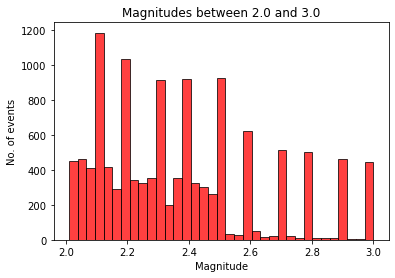

In [10]:
plt.hist(lm['source_magnitude'], bins='auto', facecolor='r', alpha=0.75, edgecolor='black')
plt.title("Magnitudes between 2.0 and 3.0")
plt.xlabel("Magnitude")
plt.ylabel('No. of events')
plt.show()

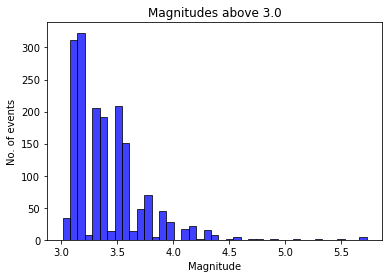

In [11]:
plt.hist(hm['source_magnitude'], bins='auto', facecolor='b', alpha=0.75, edgecolor='black')
plt.title("Magnitudes above 3.0")
plt.xlabel("Magnitude")
plt.ylabel('No. of events')
plt.show()

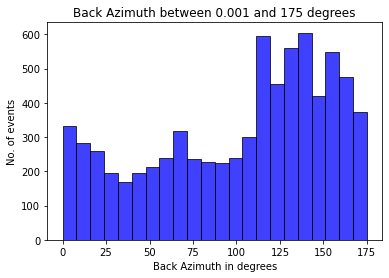

In [12]:
# Low and high baz plots

lbaz = d2[d2.back_azimuth_deg >= 0.001]
lbaz = lbaz[lbaz.back_azimuth_deg <= 175]
hbaz = d2[d2.back_azimuth_deg > 175]

plt.hist(lbaz['back_azimuth_deg'], bins='auto', facecolor='b', alpha=0.75, edgecolor='black')
plt.title("Back Azimuth between 0.001 and 175 degrees")
plt.xlabel("Back Azimuth in degrees")
plt.ylabel('No. of events')
plt.show()

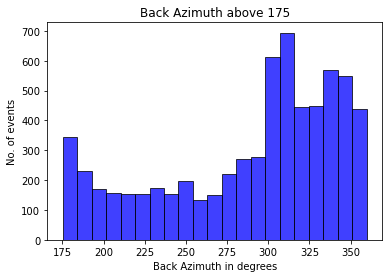

In [13]:
plt.hist(hbaz['back_azimuth_deg'], bins='auto', facecolor='b', alpha=0.75, edgecolor='black')
plt.title("Back Azimuth above 175")
plt.xlabel("Back Azimuth in degrees")
plt.ylabel('No. of events')
plt.show()

In [ ]:
# Max and mins

m_max,m_min = d2['source_magnitude'].max(),d2['source_magnitude'].min()
d_max,d_min = np.max(depth_float),np.min(depth_float)
snr_max,snr_min = d2['snr_db'].max(),d2['snr_db'].min()
baz_max,baz_min = d2['back_azimuth_deg'].max(),d2['back_azimuth_deg'].min()

print(m_max,m_min)
print(d_max,d_min)
print(snr_max,snr_min)
print(baz_max,baz_min)

In [ ]:
def wave_proc(dt, w):
    ev = dt['trace_name'].to_list()
    x = np.zeros((len(dt),6000,3),np.float32)
    y = np.zeros((len(dt),1),np.float32)

    dtf = h5py.File(w,'r')

    for c, evi in enumerate(ev):
        eg = dtf.get('data/'+str(evi))
        data = np.array(eg)
        mag = round(float(eg.attrs['source_magnitude']),2)    
        psamp = int(eg.attrs['p_arrival_sample'])
        ssamp = int(eg.attrs['s_arrival_sample'])
        BAZ = round(float(eg.attrs['back_azimuth_deg']), 2)
        dpt = eg.attrs['source_depth_km']
        dis = round(float(eg.attrs['source_distance_deg']), 2)
        SNR = eg.attrs['snr_db']
    #dshort = data[psamp-100:psamp+2900,:]
        x[c,:,:] = data
        y[c,0] = mag
    
    dtf.close()
    return x, y, x.shape, y.shape


In [ ]:
# Get waveforms of respective sets

w1, m1, wlen, mlen = wave_proc(d2,wave1)
#w2, m2, wlen2, mlen2 = wave_proc(d2,wave2)
#w3, m3, wlen3, mlen3 = wave_proc(d3,wave3)
#w4, m4, wlen4, mlen4 = wave_proc(d4,wave4)

print(wlen, mlen)

In [ ]:
## DO NOT RUN ##

# Merge data

amp_merged = np.concatenate((w1,w2,w3,w4),axis=0) 
mag_merged = np.concatenate((m1,m2,m3,m4),axis=0)

print(amp_merged.shape,mag_merged.shape)

In [ ]:
## DO NOT RUN ##

# Slice 30s window

amp_30 = amp_merged[:,:3000,:]

print(amp_30.shape)

In [ ]:
# Runs script for visualising traces
%run trace_viz.py

In [ ]:
# Time domain plots #

tplot(w1[5,:,:])

In [ ]:
tplot(amp_30[5,:,:])

In [ ]:
# Scripts for applying Hanning taper and FFT
%run hann_taper.py
%run sigproc.py

In [ ]:
# Applies taper and FFT to signals

new_amp = np.zeros((len(w1),6000,3),np.float32)
#amp_short = np.zeros((len(amp_30),3000,3),np.float32)
#tap_body = np.zeros((len(df2),6000,3),np.float32)
#tap_moment = np.zeros((len(df3),6000,3),np.float32)
for i in range(len(w1)):
    x1 = myHanningTaper(w1[i,:,0],0.1)
    x2 = myHanningTaper(w1[i,:,1],0.1)
    x3 = myHanningTaper(w1[i,:,2],0.1)
    #g = np.hstack((x1,x2,x3))
    #g = g.reshape(1,3000,3)
    new_amp[i,:,0] = x1
    new_amp[i,:,1] = x2
    new_amp[i,:,2] = x3
#ht = myHanningTaper(amp_merged)
fq = fconv(new_amp, len(new_amp), 6000)
#fq_30 = fconv(amp_short, len(amp_30), 3000)
print(fq.shape)

In [ ]:
# Frequency domain plots #

fplot(fq[5,:,:])

In [ ]:
fplot(fq_30[5,:,:])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [ ]:
# Runs script containing Tensorflow model layers as classes
%run layers_class.py

In [ ]:
# Train Test Split #

from sklearn.model_selection import train_test_split

#x1t = w1[:,:,0]
#x2t = w1[:,:,1]
#x3t = w1[:,:,2]

#xtrain, xtest, ytrain, ytest = train_test_split(fq, m1, shuffle=True, test_size=0.1)
#xtrain, ytrain = xtrain.reshape(len(xtrain),3001,3), ytrain.reshape(len(ytrain),1)
#xtest, ytest = xtest.reshape(len(xtest),3001,1), ytest.reshape(len(ytest),1)
#print(xtrain.shape, xtest.shape)

x1 = fq[:,:,0]
x2 = fq[:,:,1]
x3 = fq[:,:,2]

#train_et, test_et, ytrain_et, ytest_et = train_test_split(x1t, m1, shuffle=True, test_size=0.1)
#train_nt, test_nt, ytrain_nt, ytest_nt = train_test_split(x2t, m1, shuffle=True, test_size=0.1)
#train_zt, test_zt, ytrain_zt, ytest_zt = train_test_split(x3t, m1, shuffle=True, test_size=0.1)

train_e, test_e, ytrain_e, ytest_e = train_test_split(x1, m1, shuffle=False, test_size=0.1)
train_n, test_n, ytrain_n, ytest_n = train_test_split(x2, m1, shuffle=False, test_size=0.1)
train_z, test_z, ytrain_z, ytest_z = train_test_split(x3, m1, shuffle=False, test_size=0.1)

#train_et, test_et = train_et.reshape(len(train_et),6000,1), test_et.reshape(len(test_et),6000,1)
#train_nt, test_nt = train_nt.reshape(len(train_nt),6000,1), test_nt.reshape(len(test_nt),6000,1)
#train_zt, test_zt = train_zt.reshape(len(train_zt),6000,1), test_zt.reshape(len(test_zt),6000,1)


train_e = np.reshape(train_e, (len(train_e),3001,1))
test_e = np.reshape(test_e, (len(test_e),3001,1))
train_n = np.reshape(train_n, (len(train_n),3001,1))
test_n = np.reshape(test_n, (len(test_n),3001,1))
train_z = np.reshape(train_z, (len(train_z),3001,1))
test_z = np.reshape(test_z, (len(test_z),3001,1))

#print(train_et.shape, test_et.shape, ytrain_et.shape, ytest_et.shape)
#print(train_nt.shape, test_nt.shape, ytrain_nt.shape, ytest_nt.shape)
#print(train_zt.shape, test_zt.shape, ytrain_zt.shape, ytest_zt.shape)

print(train_e.shape, ytrain_e.shape, test_e.shape, ytest_e.shape)
print(train_n.shape, ytrain_n.shape, test_n.shape, ytest_n.shape)
print(train_z.shape, ytrain_z.shape, test_z.shape, ytest_z.shape)

# Training channel E

In [ ]:
# Training the first channel: E
epochs_number = 100
bach_size = 10
drop_rate = 0.2

#strategy = tf.distribute.MirroredStrategy()

#with strategy.scope():

inp = Input(shape=(3001,1), dtype='float32', name='input_layer')     # Input layer
#inp = tf.cast(inp, tf.int32)
# Embed frequency data #
#freq_embed = F2V(750,3001)(inp)
#freq_embed = tf.cast(freq_embed, tf.float32)
#print(K.get_value(e[:50]))
#encoder = Bidirectional(LSTM(50, return_sequences=True, dropout=0.0, recurrent_dropout=0.0))(inp)    # Bi-LSTM layer
#print(tf.shape(e))
#e = tf.reshape(inp,(3,3001))
awts, attn_out, con = attention1()(inp)                  # Bahdanau attention layer
#awts = awts.numpy()
#print(type(a))
#attn_out = tf.reshape(attn_out,(1500,200))
#e = tf.expand_dims(attn_out,axis=2)
print(tf.shape(awts))
print(tf.shape(attn_out))
#con = tf.reshape(con,(3,1))
#c = Conv1D(32, 3, padding = 'same')(attn_out) 
c = MaxPooling1D(10, padding='same')(attn_out)
#c = Conv1D(16, 3, padding='same')(c)
c = MaxPooling1D(5, padding='same')(c)
#m2 = Flatten()(m2)
e = Bidirectional(LSTM(10, return_sequences=False,dropout=0.0,recurrent_dropout=0.0))(c)

d = Dense(1)(e)                                     # Fully connected layer
o = Activation('relu', name='output_layer')(d)           # Activation layer

model_e = Model(inputs=[inp], outputs=o)

model_e.compile(optimizer='Adam', loss='Huber')

lr_reducer = ReduceLROnPlateau(monitor='val_loss',         # Reduces learning rate while training
                               factor=np.sqrt(0.1),
                                patience= 4,
                               min_lr=0.5e-10
                              )
model_e.summary()

In [ ]:
!pip install pydot
!pip install graphviz

In [ ]:
import pydot
import graphviz

In [ ]:
# Plots and saves the model
tf.keras.utils.plot_model(model_e,show_shapes=True,to_file='freq_mag.png')

In [ ]:
# Training frequency domain
start = time.perf_counter()
history = model_e.fit(train_e, ytrain_e, epochs=epochs_number, validation_split=0.1, batch_size=bach_size, callbacks = [lr_reducer])
elap = time.perf_counter() - start
print('%.3f' % elap)

In [ ]:
f1 = fq[0,:,0]
f1 = f1.reshape(3001,1)
f2 = fq[0,:,1].reshape(3001,1)
f3 = fq[0,:,2].reshape(3001,1)

print(f1.shape,f2.shape,f3.shape)

In [ ]:
# Loss Plots #

%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'], '--')
ax.legend(['loss', 'val_loss'], loc='upper right') 
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('E Channel Learning Curve')
plt.rcParams['figure.figsize'] = (5,5)
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.show()

In [ ]:
# Get attention scores


#enc = model.layers[1]
attention_layer = model_e.layers[1]
#encout = enc(train_e[0:1,:])
#xtr = xtrain[0:1,:,0]
#xtr = tf.reshape(xtr,(3001,1))
awts,_, _ = attention_layer(train_e[0:1,:])
#print(tf.reduce_max(awts),tf.reduce_min(awts))
awts = tf.reshape(awts,(3001,1))
train1 = tf.reshape(train_e[0:1,:],(3001,1))
sr = 100
fny = sr / 2.0
m = np.linspace(0,fny,len(awts))
dfe = pd.DataFrame(list(zip(train1.numpy(),m,awts.numpy(),np.repeat(ytrain_e[0],3001))))
dfe.columns = ['Amplitudes in Frequency Domain','Frequency [Hz]','Attention Scores','Magnitude']
print(dfe.head)
print(len(dfe))
#print(tf.shape(awts))
#v = yz[:1]
#v = tf.reshape(v,(3001,1))
#av = tf.concat((awts,train1),axis=1)
#print(tf.shape(av))
#merged = tf.stack((awts,train1),axis=1)
#print(tf.shape(merged))
#fig, ax = plt.subplots(figsize=(10,10))
#fig, ax = plt.subplots(ncols=2, gridspec_kw=dict(width_ratios=[5,0.5]))
#title = 'Attention Heatmap'
#plt.title(title,fontsize=15)
#plt.setp(ax.get_xticklabels(), visible=False)
#ttl = ax.title
#ax.axis('off')
#ttl.set_position([0.5,1.05])
#sns.heatmap(awts[:,:])#, annot=True, cbar=True)#, ax=axs[1])
#fig.colorbar(axs[1].collections[0], cax=axs[1])
#plt.show()

In [ ]:
dfe['Amplitudes in Frequency Domain'] = dfe['Amplitudes in Frequency Domain'].astype(float)
dfe['Attention Scores'] = dfe['Attention Scores'].astype(float)
#dfe['Attention Scores'].sum()
dfe.dtypes

In [ ]:
dfe.loc[dfe['Attention Scores'].idxmin()]

In [ ]:
dfe.loc[dfe['Attention Scores'].idxmax()]

In [ ]:
# Spearman

from scipy.stats import spearmanr

pred_e = model_e.predict(train_e)

r = spearmanr(ytrain_e,pred_e)
print(r)

In [ ]:
# Uncertainty Quantification #
%run uq_epistemic.py

In [ ]:
mc_num = 100
ep_e = uq_ec(train_e,model_e,bach_size,mc_num)

In [ ]:
ep_e = np.reshape(ep_e,(12600,1))
print(ep_e.shape)

In [ ]:
# Visualise

plt.figure()
plt.plot(ytrain_e, ep_e, 'ro', alpha=0.4)
plt.xlabel('Magnitude')
plt.ylabel('Epistemic Uncertainty')
plt.title('Epistemic Uncertainty: Channel E')
plt.show() 

In [ ]:
# Evaluate

eva = model_e.evaluate(test_e, ytest_e)
print('test loss: ',eva)

predic_e = model_e.predict(test_e)

pr = spearmanr(ytest_e,predic_e)
print(pr)

In [ ]:
# Measured Vs. Predicted

fig, ax = plt.subplots()
ax.scatter(ytest_e, predic_e, alpha = 0.4, facecolors='none', edgecolors='r')
ax.plot([ytest_e.min(), ytest_e.max()], [ytest_e.min(), ytest_e.max()], 'k--', alpha=0.4, lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Magnitude (Measured Vs. Predicted): Channel E')

# Training channel N

In [ ]:
# Training the second channel: N
epochs_number = 100
bach_size = 10
drop_rate = 0.2

#strategy = tf.distribute.MirroredStrategy()

#with strategy.scope():

inp = Input(shape=(3001,1), dtype='float32', name='input_layer') 
#inp = tf.cast(inp, tf.int32)
# Embed frequency data #
#freq_embed = F2V(750,3001)(inp)
#freq_embed = tf.cast(freq_embed, tf.float32)
#print(K.get_value(e[:50]))
#encoder = Bidirectional(LSTM(50, return_sequences=True, dropout=0.0, recurrent_dropout=0.0))(inp)
#print(tf.shape(e))
#e = tf.reshape(e,(1500,200))
awts, attn_out, con = attention1()(inp)
#awts = awts.numpy()
#print(type(a))
#attn_out = tf.reshape(attn_out,(1500,200))
#e = tf.expand_dims(attn_out,axis=2)
print(tf.shape(attn_out))

#c1 = Conv1D(64,20,padding='same')(attn_out)
m1 = MaxPooling1D(10,padding='same')(attn_out)
#c2 = Conv1D(64,20,padding='same')(m1)
m2 = MaxPooling1D(5,padding='same')(m1)

e = Bidirectional(LSTM(10,return_sequences=False,dropout=0.0,recurrent_dropout=0.0))(m2)

d = Dense(1)(e)
o = Activation('relu', name='output_layer')(d)

model_n = Model(inputs=[inp], outputs=o)

model_n.compile(optimizer='Adam', loss='Huber')

lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               factor=np.sqrt(0.1),
                                patience= 4,
                               min_lr=0.5e-10
                              )
model_n.summary()

In [ ]:
start = time.perf_counter()
history1 = model_n.fit(train_n, ytrain_n, epochs=epochs_number, validation_split=0.1, batch_size=bach_size, callbacks = [lr_reducer])
elap = time.perf_counter() - start
print('%.3f' % elap)

In [ ]:
# Get attention scores


#enc = model.layers[1]
attention_layer = model_e.layers[1]
#encout = enc(train_e[0:1,:])
awts1, _, _ = attention_layer(train_n[0:1,:])
#print(tf.reduce_max(awts),tf.reduce_min(awts))
awts1 = tf.reshape(awts1,(3001,1))
train2 = tf.reshape(train_n[0:1],(3001,1))
sr = 100
fny = sr / 2.0
m = np.linspace(0,fny,len(awts1))
dfn = pd.DataFrame(list(zip(train2.numpy(),m,awts1.numpy(),np.repeat(ytrain_n[0],3001))))
dfn.columns = ['Amplitudes in Frequency Domain','Frequency [Hz]','Attention Scores','Magnitude']
print(dfn.head)
print(len(dfn))
#print(tf.shape(awts))
#v = yz[:1]
#v = tf.reshape(v,(3001,1))
#av = tf.concat((awts,train1),axis=1)
#print(tf.shape(av))
#merged = tf.stack((awts,train1),axis=1)
#print(tf.shape(merged))
#fig, ax = plt.subplots(figsize=(10,10))
#fig, ax = plt.subplots(ncols=2, gridspec_kw=dict(width_ratios=[5,0.5]))
#title = 'Attention Heatmap'
#plt.title(title,fontsize=15)
#plt.setp(ax.get_xticklabels(), visible=False)
#ttl = ax.title
#ax.axis('off')
#ttl.set_position([0.5,1.05])
#sns.heatmap(awts[:,:])#, annot=True, cbar=True)#, ax=axs[1])
#fig.colorbar(axs[1].collections[0], cax=axs[1])
#plt.show()

In [ ]:
dfn['Amplitudes in Frequency Domain'] = dfn['Amplitudes in Frequency Domain'].astype(float)
dfn['Attention Scores'] = dfn['Attention Scores'].astype(float)
#dfe['Attention Scores'].sum()
dfn.dtypes

In [ ]:
dfn.loc[dfn['Attention Scores'].idxmin()]

In [ ]:
dfn.loc[dfn['Attention Scores'].idxmax()]

In [ ]:
# Save model

model_n.save('saved_models/Model_N')

In [ ]:
# Loss Plots #

%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history1.history['loss'])
ax.plot(history1.history['val_loss'], '--')
ax.legend(['loss', 'val_loss'], loc='upper right') 
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('N Channel Learning Curve')
plt.rcParams['figure.figsize'] = (5,5)
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.show()

In [ ]:
# Spearman

from scipy.stats import spearmanr

pred_n = model_e.predict(train_n)

r = spearmanr(ytrain_n,pred_n)
print(r)

In [ ]:
# Uncertainty Quantification #

mc_num = 100
ep_n = uq_ec(train_n,model_e,bach_size,mc_num)
ep_n = np.reshape(ep_n,(12600,1))
print(ep_n.shape)

In [ ]:
# Visualise

plt.figure()
plt.plot(ytrain_n, ep_n, 'bo', alpha=0.4)
plt.xlabel('Magnitude')
plt.ylabel('Epistemic Uncertainty')
plt.title('Epistemic Uncertainty: Channel N')
plt.show() 

In [ ]:
# Evaluate

eva1 = model_e.evaluate(test_n, ytest_n)
print('test loss: ',eva1)

predic1 = model_e.predict(test_n)

nr = spearmanr(ytest_n,predic1)

print(nr)

In [ ]:
# Measured Vs. Predicted

fig, ax = plt.subplots()
ax.scatter(ytest_n, predic1, alpha = 0.4, facecolors='none', edgecolors='b')
ax.plot([ytest_n.min(), ytest_n.max()], [ytest_n.min(), ytest_n.max()], 'k--', alpha=0.4, lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Magnitude (Measured Vs. Predicted): Channel N')

# Training channel Z

In [ ]:
# Training the third channel: Z
epochs_number = 100
bach_size = 10
drop_rate = 0.2

#strategy = tf.distribute.MirroredStrategy()

#with strategy.scope():

inp = Input(shape=(3001,1), dtype='float32', name='input_layer') 
#inp = tf.cast(inp, tf.int32)
# Embed frequency data #
#freq_embed = F2V(750,3001)(inp)
#freq_embed = tf.cast(freq_embed, tf.float32)
#print(K.get_value(e[:50]))
#encoder = Bidirectional(LSTM(50, return_sequences=True, dropout=0.0, recurrent_dropout=0.0))(inp)
#print(tf.shape(e))
#e = tf.reshape(e,(1500,200))
awts, attn_out, con = attention1()(inp)
#awts = awts.numpy()
#print(type(a))
#attn_out = tf.reshape(attn_out,(1500,200))
#e = tf.expand_dims(attn_out,axis=2)
print(tf.shape(attn_out))

#c1 = Conv1D(64,20,padding='same')(attn_out)
m1 = MaxPooling1D(10,padding='same')(attn_out)
#c2 = Conv1D(64,20,padding='same')(m1)
m2 = MaxPooling1D(5,padding='same')(m1)

e = Bidirectional(LSTM(10,return_sequences=False,dropout=0.0,recurrent_dropout=0.0))(m2)

d = Dense(1)(e)
o = Activation('relu', name='output_layer')(d)

model_z = Model(inputs=[inp], outputs=o)

model_z.compile(optimizer='Adam', loss='Huber')

lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               factor=np.sqrt(0.1),
                                patience= 4,
                               min_lr=0.5e-10
                              )
model_z.summary()

In [ ]:
start = time.perf_counter()
history2 = model_z.fit(train_z, ytrain_z, epochs=epochs_number, validation_split=0.1, batch_size=bach_size, callbacks = [lr_reducer])
elap = time.perf_counter() - start
print('%.3f' % elap)

In [ ]:
# Get attention scores


#enc = model.layers[1]
attention_layer = model_e.layers[1]
#encout = enc(train_e[0:1,:])
awts2, _, _ = attention_layer(train_z[0:1,:])
#print(tf.reduce_max(awts),tf.reduce_min(awts))
awts2 = tf.reshape(awts2,(3001,1))
train3 = tf.reshape(train_z[0:1],(3001,1))
sr = 100
fny = sr / 2.0
m = np.linspace(0,fny,len(awts2))
dfz = pd.DataFrame(list(zip(train3.numpy(),m,awts2.numpy(),np.repeat(ytrain_z[0],3001))))
dfz.columns = ['Amplitudes in Frequency Domain','Frequency [Hz]','Attention Scores','Magnitude']
print(dfz.head)
print(len(dfz))
#print(tf.shape(awts))
#v = yz[:1]
#v = tf.reshape(v,(3001,1))
#av = tf.concat((awts,train1),axis=1)
#print(tf.shape(av))
#merged = tf.stack((awts,train1),axis=1)
#print(tf.shape(merged))
#fig, ax = plt.subplots(figsize=(10,10))
#fig, ax = plt.subplots(ncols=2, gridspec_kw=dict(width_ratios=[5,0.5]))
#title = 'Attention Heatmap'
#plt.title(title,fontsize=15)
#plt.setp(ax.get_xticklabels(), visible=False)
#ttl = ax.title
#ax.axis('off')
#ttl.set_position([0.5,1.05])
#sns.heatmap(awts[:,:])#, annot=True, cbar=True)#, ax=axs[1])
#fig.colorbar(axs[1].collections[0], cax=axs[1])
#plt.show()

In [ ]:
dfz['Amplitudes in Frequency Domain'] = dfz['Amplitudes in Frequency Domain'].astype(float)
dfz['Attention Scores'] = dfz['Attention Scores'].astype(float)
#dfe['Attention Scores'].sum()
dfz.dtypes

In [ ]:
dfz['Attention Scores'].sum()

In [ ]:
dfz.loc[dfz['Attention Scores'].idxmax()]

In [ ]:
dfz.loc[dfz['Attention Scores'].idxmin()]

In [ ]:
# Save model

model_z.save('saved_models/Model_Z')

In [ ]:
# Loss Plots #

%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(history2.history['loss'])
ax.plot(history2.history['val_loss'], '--')
ax.legend(['loss', 'val_loss'], loc='upper right') 
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Z Channel Learning Curve')
plt.rcParams['figure.figsize'] = (5,5)
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.show()

In [ ]:
# Spearman

from scipy.stats import spearmanr

pred_z = model_e.predict(train_z)

r = spearmanr(ytrain_z,pred_z)
print(r)

In [ ]:
# Uncertainty Quantification #

mc_num = 100
ep_z = uq_ec(train_z,model_e,bach_size,mc_num)

In [ ]:
ep_z = np.reshape(ep_z,(12600,1))
print(ep_z.shape)

In [ ]:
# Visualise

plt.figure()
plt.plot(ytrain_z, ep_z, 'g-', alpha=0.4)
plt.xlabel('Magnitude')
plt.ylabel('Epistemic Uncertainty')
plt.title('Epistemic Uncertainty: Channel Z')
plt.show() 

In [ ]:
# Evaluate

eva2 = model_e.evaluate(test_z, ytest_z)
print('test loss: ',eva2)

predic2 = model_e.predict(test_z)

zr = spearmanr(ytest_z,predic2)

print(zr)

In [ ]:
# Measured Vs. Predicted

fig, ax = plt.subplots()
ax.scatter(ytest_z, predic2, alpha = 0.4, facecolors='none', edgecolors='g')
ax.plot([ytest_z.min(), ytest_z.max()], [ytest_z.min(), ytest_z.max()], 'k--', alpha=0.4, lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Magnitude (Measured Vs. Predicted): Channel Z')